##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

### Download and prepare the MNIST dataset


This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data(path="mnist.npz")
print(train_images.shape)

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

(60000, 28, 28)


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


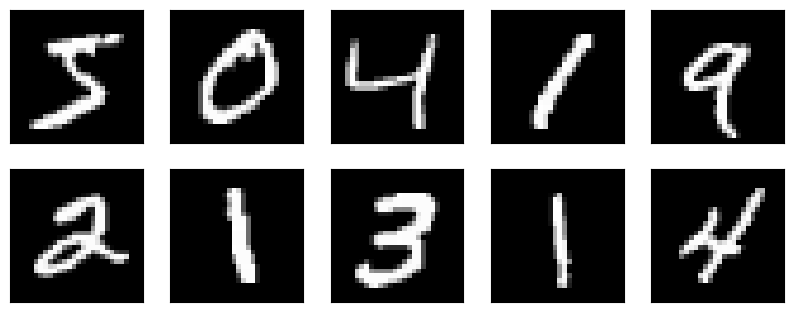

In [4]:
#class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    #plt.xlabel(class_names[train_labels[i][0]])
plt.show()

#Extract data subset

We are going to extract a small data subset to perform a first training. Then, we will train the same network with a larger amount of data to check the impact of having more data samples.

In [5]:
train_images_subset = train_images[0:500]
train_labels_subset = train_labels[0:500]

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 55744 

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. MNIST has 10 output classes, so you use a final Dense layer with 10 outputs.

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the models
First, we will train the model with a data subset.

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images_subset, train_labels_subset, epochs=15,
                    validation_data=(test_images, test_labels))

Epoch 1/15
16/16 [==============================] - 6s 127ms/step - loss: 2.1555 - accuracy: 0.3160 - val_loss: 1.8246 - val_accuracy: 0.4732
Epoch 2/15
16/16 [==============================] - 1s 98ms/step - loss: 1.1953 - accuracy: 0.6620 - val_loss: 0.8835 - val_accuracy: 0.7185
Epoch 3/15
16/16 [==============================] - 1s 77ms/step - loss: 0.5768 - accuracy: 0.8260 - val_loss: 0.6665 - val_accuracy: 0.7751
Epoch 4/15
16/16 [==============================] - 1s 93ms/step - loss: 0.4229 - accuracy: 0.8760 - val_loss: 0.6517 - val_accuracy: 0.7893
Epoch 5/15
16/16 [==============================] - 1s 94ms/step - loss: 0.3533 - accuracy: 0.8920 - val_loss: 0.4572 - val_accuracy: 0.8515
Epoch 6/15
16/16 [==============================] - 3s 180ms/step - loss: 0.2627 - accuracy: 0.9300 - val_loss: 0.4487 - val_accuracy: 0.8642
Epoch 7/15
16/16 [==============================] - 1s 91ms/step - loss: 0.1854 - accuracy: 0.9360 - val_loss: 0.3840 - val_accuracy: 0.8800
Epoch 8/15


Now we will train with the whole dataset

In [11]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10))

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model2.fit(train_images, train_labels, epochs=15,
                    validation_data=(test_images, test_labels))

Epoch 1/15
1875/1875 [==============================] - 11s 4ms/step - loss: 0.1484 - accuracy: 0.9546 - val_loss: 0.0465 - val_accuracy: 0.9855
Epoch 2/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0456 - accuracy: 0.9855 - val_loss: 0.0320 - val_accuracy: 0.9898
Epoch 3/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0338 - accuracy: 0.9892 - val_loss: 0.0343 - val_accuracy: 0.9900
Epoch 4/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0265 - accuracy: 0.9916 - val_loss: 0.0259 - val_accuracy: 0.9921
Epoch 5/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0212 - accuracy: 0.9935 - val_loss: 0.0347 - val_accuracy: 0.9897
Epoch 6/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 0.0285 - val_accuracy: 0.9911
Epoch 7/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0301 - val_accuracy

### Evaluate the models

313/313 - 1s - loss: 0.4524 - accuracy: 0.8921 - 631ms/epoch - 2ms/step


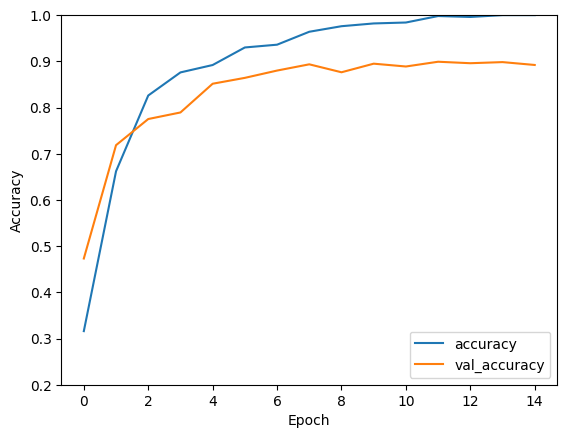

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [15]:
print(test_acc)

0.8920999765396118


313/313 - 1s - loss: 0.0437 - accuracy: 0.9923 - 818ms/epoch - 3ms/step


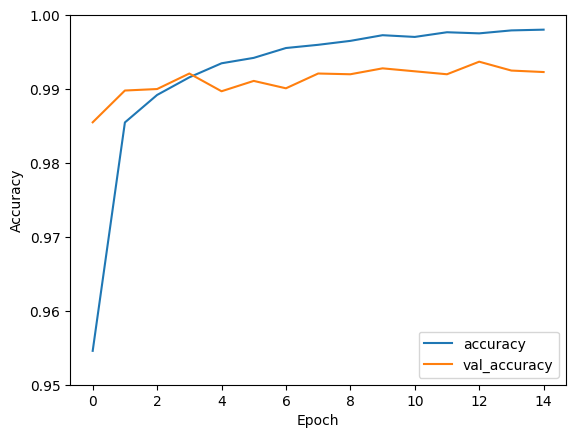

In [16]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95, 1])
plt.legend(loc='lower right')

test_loss2, test_acc2 = model2.evaluate(test_images,  test_labels, verbose=2)

In [17]:
print(test_acc2)

0.9922999739646912


Your simple CNN has achieved a test accuracy of almost 100%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.